# Elasticity
First import the required libraries for basic algebra and plotting

In [15]:
from numpy import *
set_printoptions(suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline

### Mesh
This time, we will generate the mesh, rather than writing the values manually.

In [16]:

# Make a rectangular mesh of triangles, nx by ny 
nx = 16
ny = 12

c = 0
geometry = zeros((nx*ny, 2), dtype='float')
for i in range(nx):
    for j in range(ny):
        geometry[c] = [float(i), float(j)]
        c += 1

ntri = (nx - 1)*(ny - 1)*2
topology = zeros((ntri, 3), dtype='int')

c = 0
for i in range(nx - 1):
    for j in range(ny - 1):
        ij = j + i*ny
        topology[c] = [ij, ij+ny, ij+ny+1]
        topology[c + 1] = [ij+1, ij, ij+ny+1]
        c += 2
        
mesh = (geometry, topology)

Here is a simple plotting routine to display the mesh, and also the data values, if we have any

In [17]:
def plot(mesh, data=None):
    geom, topo = mesh
    x = geom[:,0]
    y = geom[:,1]

   # plt.gca(aspect='equal')
    
    if data is not None:
        if (len(data) == len(geom)):
            # If data is one value per point, just plot it
            mag = data
        else:
            # For elasticity, we have two components, ux and uy, so here display the magnitude.
            assert(len(data) == 2*len(geom))
            ux = data[0::2]
            uy = data[1::2]
            mag = sqrt(ux**2 + uy**2)
        plt.tricontourf(x, y, topo, mag, 40)
    
    plt.triplot(x, y, topo, color='k', alpha=0.5)

    xmax = x.max()
    xmin = x.min()
    ymax = y.max()
    ymin = y.min()
    dx = 0.1*(xmax - xmin)
    dy = 0.1*(ymax - ymin)
    plt.xlim(xmin-dx, xmax+dx)
    plt.ylim(ymin-dy, ymax+dy)
    return


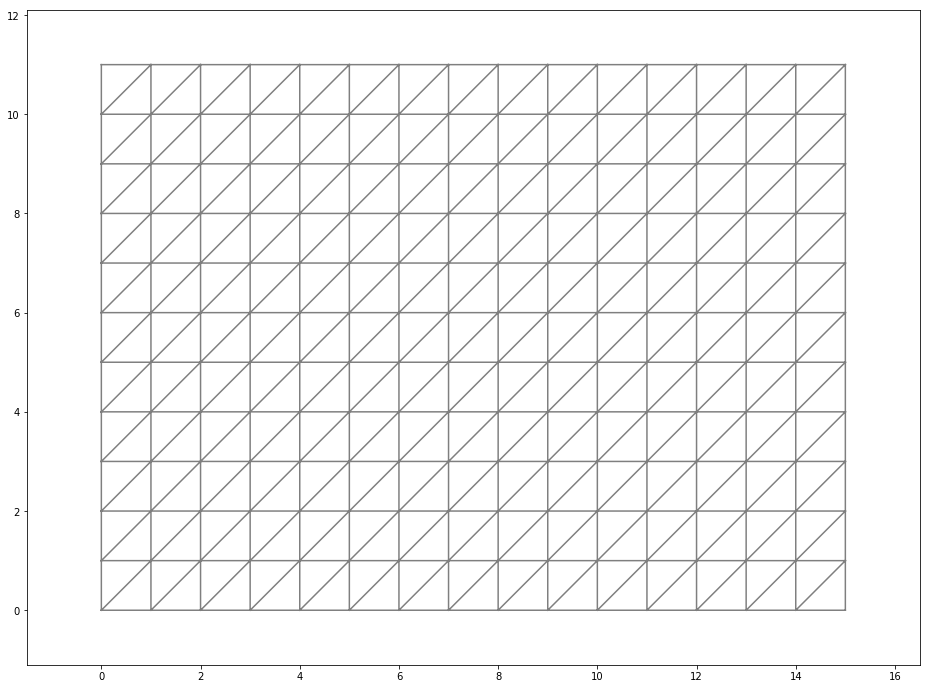

In [18]:
plt.figure(figsize=(16,16))
plt.gca(aspect='equal')
plot(mesh)

### Element matrix
The "element stiffness matrix", $K$ depends on the triangle geometry.

$$ K_e = \int_{\Omega_e} B_e^T D B_e d\Omega $$


In [19]:
def Kmat(D, p, geometry):
    ''' Calculate K from the D matrix and the points '''
    # D contains the constitutive tensor
    # p contains the indices of the three points
    # making up the triangle
    assert(len(p) == 3)
    x0, y0 = geometry[p[0]]
    x1, y1 = geometry[p[1]]
    x2, y2 = geometry[p[2]]

    # Element area Ae
    Ae = 0.5*abs((x0 - x1)*(y2 - y1) - (y0 - y1)*(x2 - x1))

    # 'B' Matrix
    B = array([[y1 - y2,     0.0, y2 - y0,     0.0, y0 - y1,     0.0],
               [    0.0, x2 - x1,     0.0, x0 - x2,     0.0, x1 - x0],
               [x2 - x1, y1 - y2, x0 - x2, y2 - y0, x1 - x0, y0 - y1]])/(2*Ae)

    # K will be a 6x6 'local element matrix'
    K = Ae*matmul(B.transpose(), matmul(D, B))
    return K

### Matrix assembly (LHS)
The process of combining the local element matrices into a larger global matrix is called "assembly". It is really just a case of relabelling the indices with their global values, and adding the local matrices together. Note that the local matrices are $(6\times 6)$, with two components at each node, stored as $u^0_x u^0_y u^1_x u^1_y u^2_x u^2_y$.

In [20]:
def assemble_matrix(mesh, Dmat):
    geom, topo = mesh
    np = len(geom)*2
    Kglobal = zeros((np, np))
    
    for tri in topo:
        K = Kmat(Dmat, tri, geom)
        # Make global indices for ux and uy components
        entries = empty(6, dtype='int')
        entries[0::2] = tri*2
        entries[1::2] = tri*2 + 1
        for i, idx in enumerate(entries):
            for j, jdx in enumerate(entries):
                Kglobal[idx, jdx] += K[i, j]
    return Kglobal

In [21]:
# Calculate a 'D' matrix for the constitutive relation
E = 10.0
nu = 0.3

Dmat = (E/(1-nu*nu)) * array([[1.0,  nu, 0.0],
                              [ nu, 1.0, 0.0],
                              [0.0, 0.0, (1-nu)/2.0]])

In [22]:
Kglobal = assemble_matrix(mesh, Dmat)

The fully assembled left-hand side (LHS) looks like this (image shows non-zero entries in black):

[[ 7.41758242  0.         -1.92307692 ...  0.          0.
   0.        ]
 [ 0.          7.41758242  1.64835165 ...  0.          0.
   0.        ]
 [-1.92307692  1.64835165 14.83516484 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 14.83516484  1.92307692
  -5.49450549]
 [ 0.          0.          0.         ...  1.92307692  7.41758242
   0.        ]
 [ 0.          0.          0.         ... -5.49450549  0.
   7.41758242]]


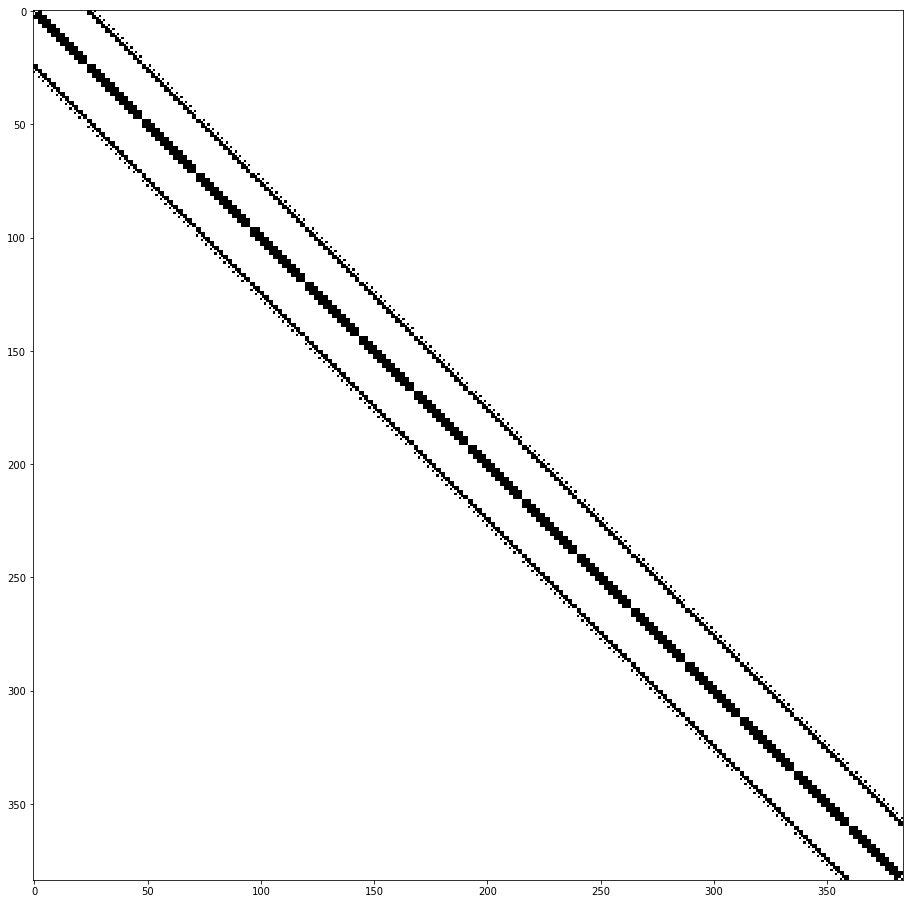

In [23]:
print(Kglobal)
# Show the non-zero structure of the matrix
plt.figure(figsize=(16,16))
nz = plt.imshow((Kglobal != 0), interpolation='nearest', cmap='Greys')

### RHS assembly

Now we could also perform RHS assembly on the vector $f$, combining the local vector entries from each element. However, if the RHS is zero (no source terms), we can safely just use a vector full of zeros.

In [24]:
geom, topo = mesh
fglobal = zeros(len(geom)*2)

#### Boundary conditions

Since we have no source terms, the solution will only be interesting if we have some non-zero boundary conditions. These can be set by clearing a row in the $K$ matrix, setting the diagonal to 1, and putting the value in the RHS $f$.

In [25]:
def set_bc(K, f, row, val):
    # Set BC
    K[row] = 0.0
    K[row, row] = 1.0
    f[row] = val

# Set ux=0.5 BC on left edge
# Set ux=uy=0.0 BC on bottom edge
# Set ux=uy=0.0 BC on top right corner

for i,x in enumerate(geometry):
    if x[1]==0:
        set_bc(Kglobal, fglobal, i*2, 0.0)
        set_bc(Kglobal, fglobal, i*2+1, 0.0)
    if x[0]==0:
        set_bc(Kglobal, fglobal, i*2, 0.5)
    if x[0]==15 and x[1]==11:
        set_bc(Kglobal, fglobal, i*2, 0.0)
        set_bc(Kglobal, fglobal, i*2+1, 0.0)

Finally, we can refer the $K.u = f$ problem to a linear algebra solver which will use an LU method to get the answer

In [26]:
u = linalg.solve(Kglobal, fglobal)
print(u.max(), u.min())


0.5000000000000031 -0.07844032950308884


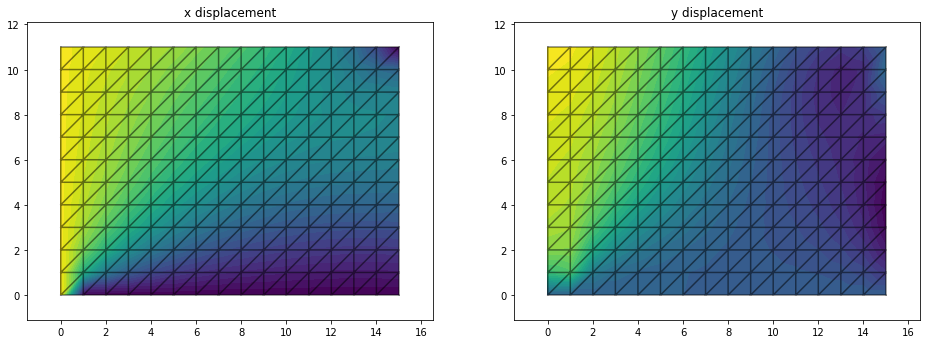

In [27]:
# Plot the displacement
ux = u[0::2]
uy = u[1::2]

plt.figure(figsize=(16,6))
plt.subplot(121, adjustable='box', aspect=1)
plt.title('x displacement')
plot(mesh, ux)
plt.subplot(122, adjustable='box', aspect=1)
plt.title('y displacement')
plot(mesh, uy)

### Move the mesh
In order to visualise the result, we can move the mesh points slightly. Remember that the solution is to a linear equation, so any large displacements will not be accurate.

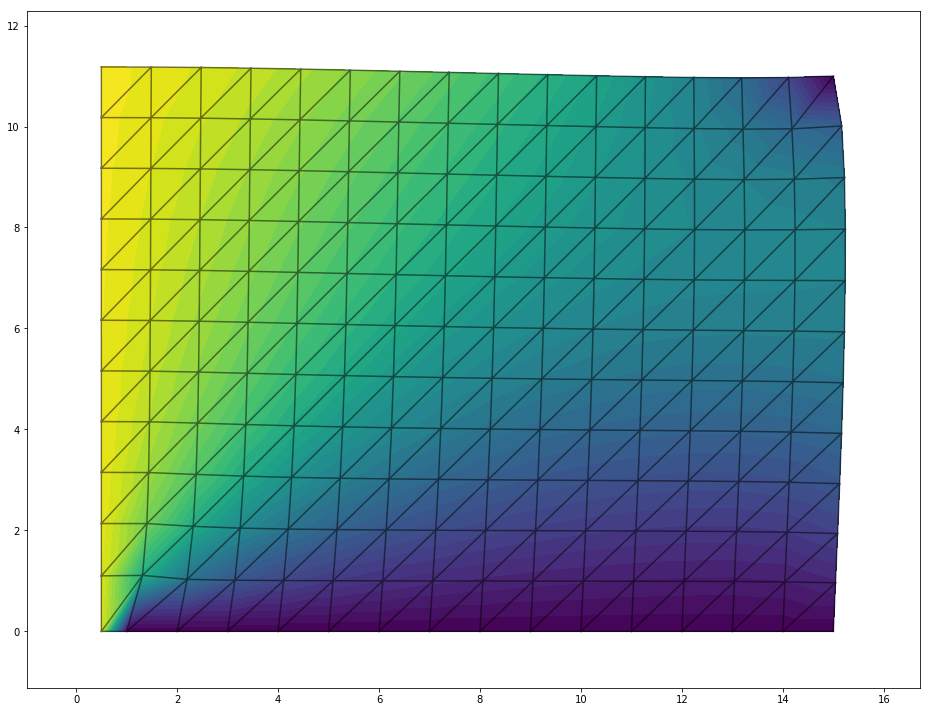

In [28]:
def move_mesh(mesh, u):
    geom, topo = mesh
    np = len(geom)
    assert(len(u) == np*2)
    # Make the displacement vector into a (np x 2) array
    v = u.reshape((np, 2))
    # Add displacement on to point positions
    for (x, dx) in zip(geom, v):
        x += dx

# Make a copy of the mesh to move 
mesh_copy = (array(mesh[0]),array(mesh[1]))
move_mesh(mesh_copy, u)

plt.figure(figsize=(16, 16))
plt.gca(aspect='equal')
plot(mesh_copy, u)

### Experimentation
Try to change the code by adjusting the constitutive relation, or boundary conditions, and re-run the notebook.